### Проект 7 
# Приоретизация гипотез, А/В тестирование и анализ результатов.

### Описание проекта: 

Я — аналитик крупного интернет-магазина. Вместе с отделом маркетинга я подготовил список гипотез для увеличения выручки.
1. Приоритизирем гипотезы, 
2. Запустим A/B-тест и проанализируем результаты.

### Описание данных: 

#### Данные для первой части

Файл /datasets/hypothesis.csv. 
 - Hypothesis — краткое описание гипотезы;
 - Reach — охват пользователей по 10-балльной шкале;
 - Impact — влияние на пользователей по 10-балльной шкале;
 - Confidence — уверенность в гипотезе по 10-балльной шкале;
 - Efforts — затраты ресурсов на проверку гипотезы по 10-балльной шкале. Чем больше значение Efforts, тем дороже проверка гипотезы.
 
#### Данные для второй части

Файл /datasets/orders.csv. 
 - transactionId — идентификатор заказа;
 - visitorId — идентификатор пользователя, совершившего заказ;
 - date — дата, когда был совершён заказ;
 - revenue — выручка заказа;
 - group — группа A/B-теста, в которую попал заказ.
 
Файл /datasets/visitors.csv.
 - date — дата;
 - group — группа A/B-теста;
 - visitors — количество пользователей в указанную дату в указанной группе A/B-теста

In [300]:
# Загрузим нужные библиотеки: 
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import datetime as dt
import numpy as np

### Загрузим и проверим данные: 

In [301]:
try:
    hypothesis = pd.read_csv('hypothesis.csv')
    orders = pd.read_csv('orders.csv')
    visitors = pd.read_csv('visitors.csv')
except:
    hypothesis = pd.read_csv('/datasets/hypothesis.csv')
    orders = pd.read_csv('/datasets/orders.csv')
    visitors = pd.read_csv('/datasets/visitors.csv')

In [302]:
pd.set_option('display.max_colwidth', None)

In [303]:
orders.head()

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


In [304]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transactionId  1197 non-null   int64 
 1   visitorId      1197 non-null   int64 
 2   date           1197 non-null   object
 3   revenue        1197 non-null   int64 
 4   group          1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB


In [305]:
orders.isna().sum()

transactionId    0
visitorId        0
date             0
revenue          0
group            0
dtype: int64

In [306]:
orders.duplicated().sum()

0

In [372]:
visitors.head()

,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


In [373]:
visitors['group'].unique()

array(['A', 'B'], dtype=object)

In [308]:
visitors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      62 non-null     object
 1   group     62 non-null     object
 2   visitors  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


In [309]:
visitors.isna().sum()

date        0
group       0
visitors    0
dtype: int64

In [310]:
visitors.duplicated().sum()

0

In [311]:
# Посчитаем сколько пользователей(если такие есть) попали в обе группы:
duplicate_users_in_order = orders.groupby('visitorId').agg({'group' : 'nunique'}).query('group>1').count()
duplicate_users_in_order

group    58
dtype: int64

In [312]:
# Посчитаем кол-во уникальных пользователей в таблице orders:
unique_users_in_irders = orders['visitorId'].nunique()
unique_users_in_irders

1031

In [313]:
# Посчитаем долю пользователей попавших в обе группы от общего числа уникальных пользователей:
duplicate_users_share = duplicate_users_in_order / unique_users_in_irders *100
duplicate_users_share.round(1)

group    5.6
dtype: float64

**Вывод:** 

В ходе предварительной проверки данных выявлено что 5.6% пользователей попадают в обе группы.

       - Исходя из того что их кол-во небольшое и при этом не влияет на общее кол-во в обеих группах, оставим их.
       - Желательно уточнить у того кто собирал данные: "Что пошло не так?"

## Часть 1. Приоритизация гипотез.

 #### Используем для приоретизации фреймворки ICE и RICE.
 
 Фреймворк ICE (от англ. impact, confidence, effort / ease «влияние, уверенность, усилия / простота») — один из самых популярных способов приоритизации задач.
 
**ICE SCORE = IMPACT * CONFIDENCE / EFFORTS**

Фреймворк RICE - разновидность ICE, дополнительно к нему имеет параметр Reach:

**RICE SCORE = REACH * IMPACT * CONFIDENCE / EFFORTS**

- Reach — скольких пользователей затронет изменение, которое вы хотите внести;
- Impact — насколько сильно изменение повлияет на пользователей, их опыт и удовлетворение от продукта;
- Confidence — насколько вы уверены, что это изменение повлияет на пользователей именно так; 
- Efforts — сколько стоит протестировать эту гипотезу.

#### Применим фреймворк ICE для приоритизации гипотез. Отсортируем их по убыванию приоритета.

In [314]:
hypothesis['ICE'] = hypothesis['Impact'] * hypothesis['Confidence'] / hypothesis['Efforts']

In [315]:
display(hypothesis[['Hypothesis','ICE']].sort_values(by='ICE',ascending=False))

,Hypothesis,ICE
8,"Запустить акцию, дающую скидку на товар в день рождения",16.200000
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",13.333333
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",11.200000
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",8.000000
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",7.000000
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2.000000
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",1.333333
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",1.125000
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",1.000000


#### Применим фреймворк RICE для приоритизации гипотез. Отсортируем их по убыванию приоритета.

In [316]:
hypothesis['RICE'] = hypothesis['Reach'] * hypothesis['Impact'] * hypothesis['Confidence'] / hypothesis['Efforts']

In [317]:
display(hypothesis.sort_values(by='RICE',ascending=False))

,Hypothesis,Reach,Impact,Confidence,Efforts,ICE,RICE
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5,11.200000,112.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3,7.000000,56.0
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6,13.333333,40.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3,8.000000,40.0
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5,16.200000,16.2
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8,1.125000,9.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10,2.000000,4.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3,1.333333,4.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1,1.000000,3.0


#### Вывод:

При применении RICE гипотезы поменялись местами, по сравнению с ICE.
- На 1 место(с 3его) встала гипотеза № 7 
- На 2 место (с 5го) - гипотеза № 2
- Гипотеза 0 потеряла 1у позицию но осталась в тройке лучших.

Причины изменениня связаны с тем что при расчете RICE на первые места вышли гипотезы с высоким показателем Reach (который в ICE никак не учитывался).

## Часть 2. Анализ A/B-теста

Результаты проведенного А/В теста описаны в файлах /datasets/orders.csv и /datasets/visitors.csv

In [318]:
display(orders.head())
visitors.head()

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


In [376]:
print('Минимальная дата заказа', orders['date'].min())
print('Дата последнего заказа',orders['date'].max())
print('Минимальная дата привлечения пользователя', visitors['date'].min())
print('Дата привлечения последнего пользователя',visitors['date'].max())

Минимальная дата заказа 2019-08-01
Дата последнего заказа 2019-08-31
Минимальная дата привлечения пользователя 2019-08-01
Дата привлечения последнего пользователя 2019-08-31


### 2.1 Строим график кумулятивной выручки по группам:

In [377]:
# Создаем массив уникальных пар значений дат и групп теста
datesGroups = orders[['date','group']].drop_duplicates() 

In [321]:
# Соберём агрегированные кумулятивные по дням данные о заказах:
ordersAggregated = (
    datesGroups.apply(lambda x: orders[np.logical_and(orders['date'] <= x['date'], orders['group'] == x['group'])]
    .agg({'date' : 'max', 'group' : 'max', 'transactionId' : 'nunique', 'visitorId' : 'nunique', 'revenue' : 'sum'}), axis=1)
    .sort_values(by=['date','group'])
)

In [322]:
# Аналогично получим агрегированные кумулятивные по дням данные о посетителях:
visitorsAggregated = (
    datesGroups.apply(lambda x: visitors[np.logical_and(visitors['date'] <= x['date'], visitors['group'] == x['group'])]
    .agg({'date' : 'max', 'group' : 'max', 'visitors' : 'sum'}), axis=1)
    .sort_values(by=['date','group'])
)

In [378]:
# Объединяем кумулятивные данные в одной таблице и присваиваем ее столбцам понятные названия
cumulativeData = ordersAggregated.merge(visitorsAggregated, left_on=['date', 'group'], right_on=['date', 'group'])
cumulativeData.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']
cumulativeData.head()

,date,group,orders,buyers,revenue,visitors
0,2019-08-01,A,24,20,148579,719
1,2019-08-01,B,21,20,101217,713
2,2019-08-02,A,44,38,242401,1338
3,2019-08-02,B,45,43,266748,1294
4,2019-08-03,A,68,62,354874,1845


In [324]:
# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе А
cumulativeRevenueA = cumulativeData[cumulativeData['group']=='A'][['date','revenue', 'orders']]

# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе B
cumulativeRevenueB = cumulativeData[cumulativeData['group']=='B'][['date','revenue', 'orders']]

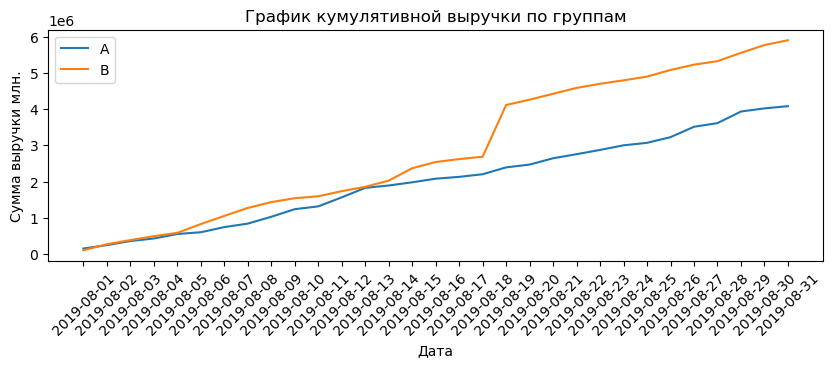

In [325]:
plt.figure(figsize=(10, 3))
plt.xticks(rotation=45)

# Строим график выручки группы А
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue'], label='A')

# Строим график выручки группы B
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue'], label='B')

plt.title('График кумулятивной выручки по группам')
plt.xlabel('Дата')
plt.ylabel('Сумма выручки млн.')

plt.legend()
plt.show()

 **Вывод:** 
 - Кум выручка группы А росла стабильно и пловно
 - Кум выручка группы В росла идентично гр. А до 18 авг. Далее 19 августа произошел резкий выброс.
 - Возможной причиной выброса группе В может быть:
     1. крупный заказ от 1 или неск покупателей или 
     2. резкий рост кол-ва заказов из-за доп факторов (например: маркетинговая акция, новости о дециците товара и тп...)
 - После 19 авг выручка в обеих группах продолжает идентичный рост

### 2.2 Строим график кумулятивного среднего чека по группам:

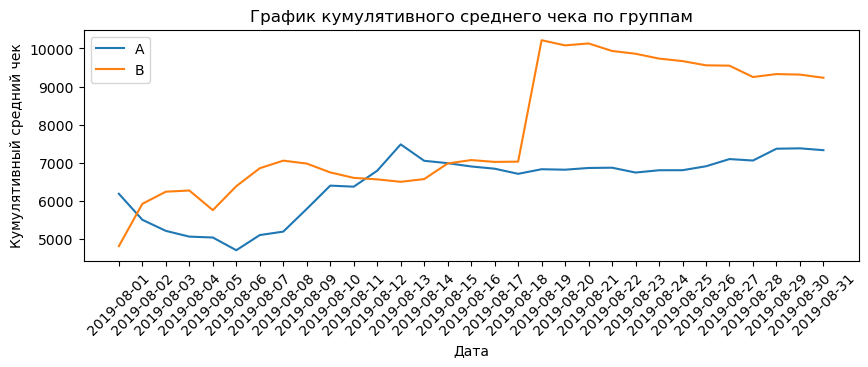

In [326]:
plt.figure(figsize=(10, 3))
plt.xticks(rotation=45)

# график кумулятивного среднего чека группы А
plt.plot(cumulativeRevenueA['date'],cumulativeRevenueA['revenue']/cumulativeRevenueA['orders'],label='A')

# график кумулятивного среднего чека группы В
plt.plot(cumulativeRevenueB['date'],cumulativeRevenueB['revenue']/cumulativeRevenueB['orders'],label='B')

plt.title('График кумулятивного среднего чека по группам')
plt.xlabel('Дата')
plt.ylabel('Кумулятивный средний чек')

plt.legend()
plt.show()

**Вывод:**
- В начале теста, в районе 8 авг. видны расхождения пок-ля
- Далее с 9 по 18 авг пок-ль по группам выравнивается 
- Как и на графике Кум выручки(выше), явно виден выброс 19авг в группе В, из-за чего её пок-ль сильно вырос по сравн с группой А.
- Примерно с 20авг и далее явно виден тренд того что пок-ль ср чека группы В стремится к пок-лю ср чека группы А

### 2.3 Строим график относительного изменения кумулятивного среднего чека группы B к группе A:

In [327]:
#  Объединим данные кум выручки групп А и В в одну таблицу:
mergedCumulativeRevenue = (
    cumulativeRevenueA.merge(cumulativeRevenueB,left_on='date', right_on='date', how='left', suffixes=['A', 'B'])
)

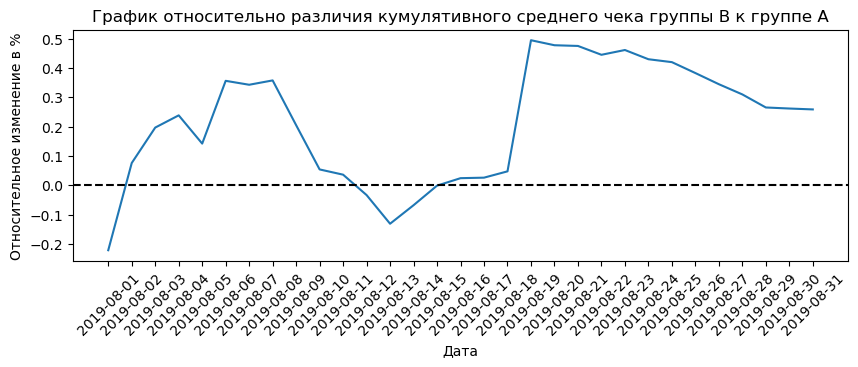

In [328]:
plt.figure(figsize=(10, 3))
plt.xticks(rotation=45)

# Строим график относительно различия кумулятивного среднего чека группы B к группе A:
plt.plot(mergedCumulativeRevenue['date'],(mergedCumulativeRevenue['revenueB']/mergedCumulativeRevenue['ordersB'])/(mergedCumulativeRevenue['revenueA']/mergedCumulativeRevenue['ordersA'])-1)

plt.axhline(y=0,color='black',linestyle='--')

plt.title('График относительно различия кумулятивного среднего чека группы B к группе A')
plt.xlabel('Дата')
plt.ylabel('Относительное изменение в %')

plt.show()

**Вывод:**
- В начале теста, в районе 8 авг. видны расхождения пок-ля. По группе В есть относительный рост. 
- Далее с 9 по 17 авг пок-ль по группам выравнивается.
- Явно виден выброс 18авг в группе В, из-за чего её пок-ль сильно вырос(~30%) по сравнению с группой А.
- Примерно с 20авг и далее явно виден тренд того что пок-ль ср чека группы В стремится к пок-лю ср чека группы А

### 2.4 Строим график кумулятивного среднего количества заказов на посетителя по группам:

In [329]:
# Добавим в cumulativeData столбец 'orders_per_buyers'
# c средним кол-вом заказов на 1го польз-ля указанной группе в указанный день:
cumulativeData['orders_per_buyers'] = round(cumulativeData['orders'] / cumulativeData['buyers'],2)
cumulativeData.head()

,date,group,orders,buyers,revenue,visitors,orders_per_buyers
0,2019-08-01,A,24,20,148579,719,1.20
1,2019-08-01,B,21,20,101217,713,1.05
2,2019-08-02,A,44,38,242401,1338,1.16
3,2019-08-02,B,45,43,266748,1294,1.05
4,2019-08-03,A,68,62,354874,1845,1.10


In [330]:
# датафрейм с кумулятивным средним кол-вом заказов по группе А:
cumulativeDataA = cumulativeData[cumulativeData['group'] == 'A']

# датафрейм с кумулятивным средним кол-вом заказов по группе А:
cumulativeDataB = cumulativeData[cumulativeData['group'] == 'B']

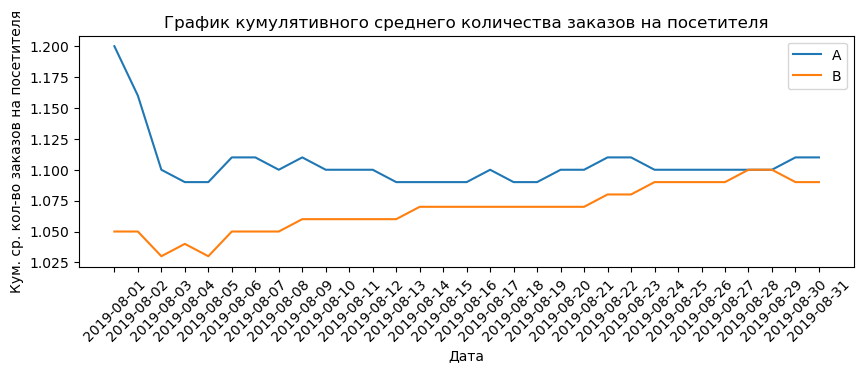

In [331]:
plt.figure(figsize=(10, 3))
plt.xticks(rotation=45)

plt.plot(cumulativeDataA['date'],cumulativeDataA['orders_per_buyers'],label='A')
plt.plot(cumulativeDataB['date'], cumulativeDataB['orders_per_buyers'], label='B')

plt.title('График кумулятивного среднего количества заказов на посетителя')
plt.xlabel('Дата')
plt.ylabel('Кум. ср. кол-во заказов на посетителя')

plt.legend()
plt.show()

**Вывод:**
- В начале теста ср кол-во заказов в группе А было немного больше чем в группе B, 1.2 и 1.025 соответственно.
    - Причиной может быть то, что в группу А попали заказы из отложенного спроса, чего не может быть в группе В
- Втечение месяца показатели групп А и В стремились друг к другу
- 27авг. показатели выровнялись и Ср. кол-во заказов на 1 польз-ля в обеих группах  = 1.1

### 2.5 Строим график относительного изменения кумулятивного среднего количества заказов на посетителя группы B к группе A:

In [332]:
#  Объединим данные кум заказов групп А и В в одну таблицу:
mergedCumulativeOrders = cumulativeDataA[['date','orders_per_buyers']].merge(
    cumulativeDataB[['date','orders_per_buyers']],left_on='date',right_on='date', suffixes=['A','B'])
mergedCumulativeOrders.head()

,date,orders_per_buyersA,orders_per_buyersB
0,2019-08-01,1.20,1.05
1,2019-08-02,1.16,1.05
2,2019-08-03,1.10,1.03
3,2019-08-04,1.09,1.04
4,2019-08-05,1.09,1.03


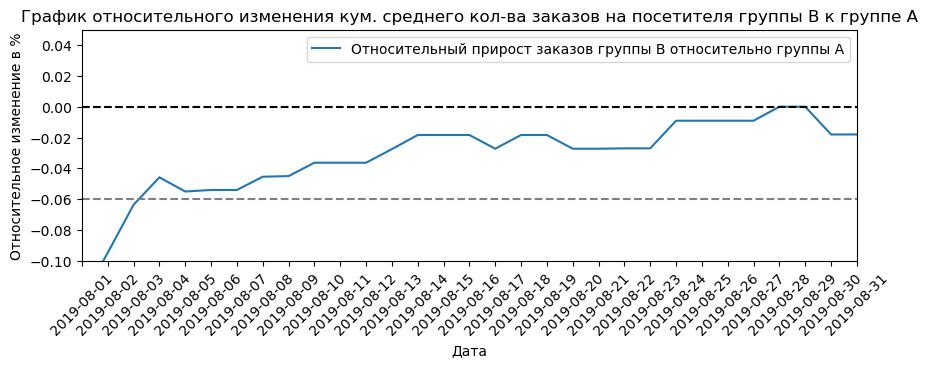

In [333]:
plt.figure(figsize=(10, 3))
plt.xticks(rotation=45)

plt.plot(mergedCumulativeOrders['date'],\
         mergedCumulativeOrders['orders_per_buyersB']/mergedCumulativeOrders['orders_per_buyersA']-1,\
         label="Относительный прирост заказов группы B относительно группы A")

plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=-0.06, color='grey', linestyle='--')
plt.axis(['2019-08-01','2019-08-31', -0.1, 0.05])

plt.title('График относительного изменения кум. среднего кол-ва заказов на посетителя группы B к группе A')
plt.xlabel('Дата')
plt.ylabel('Относительное изменение в %')

plt.legend()
plt.show()

**Вывод:**
- Кол-во заказов в группе В ни разу не превысело аналогичный пок-ль в группе А, но сравнялось с ним к конце августа

### 2.6 Строим точечный график количества заказов по пользователям:

In [334]:
ordersByUsers = (
    orders.groupby('visitorId',as_index=False)
    .agg({'transactionId':'nunique'})
)
ordersByUsers.columns = ['userId', 'orders']
ordersByUsers.head()

,userId,orders
0,5114589,1
1,6958315,1
2,8300375,2
3,11685486,1
4,39475350,1


In [335]:
# серия из чисел от 0 до количества наблюдений в ordersByUsers
x_values = pd.Series(range(0, len(ordersByUsers)))

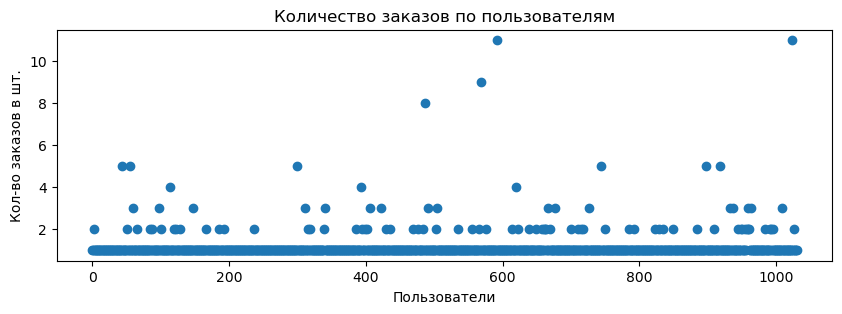

In [336]:
plt.figure(figsize=(10,3))
plt.scatter(x_values,ordersByUsers['orders'])
plt.title('Количество заказов по пользователям')
plt.xlabel('Пользователи')
plt.ylabel('Кол-во заказов в шт.')
plt.show()

**Вывод:**
- У большинства польз-лей только 1 заказ
- также на графике видно, что много пользователей с 2мя заказами
- От 3х заказаов и более, чем дальше, тем меньше
- Максимальное чило заказов 11

### 2.7 Посчитаем 95-й и 99-й перцентили количества заказов на пользователя: 
Выберем границу для определения аномальных пользователей.

In [337]:
np.percentile(ordersByUsers['orders'],[95, 99])

array([2., 4.])

- Не более 5% польз-лей совершали 2 заказа
- Не более 1% пользователей совершали 4 заказа

### 2.8 Строим точечный график стоимостей заказов:

In [338]:
x_values = pd.Series(range(0, len(orders['revenue'])))

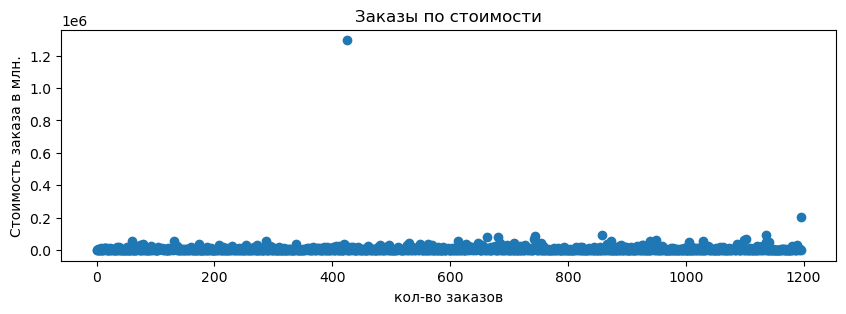

In [339]:
plt.figure(figsize=(10,3))
plt.scatter(x_values,orders['revenue'])
plt.title('Заказы по стоимости')
plt.xlabel('кол-во заказов')
plt.ylabel('Стоимость заказа в млн.')

plt.show()

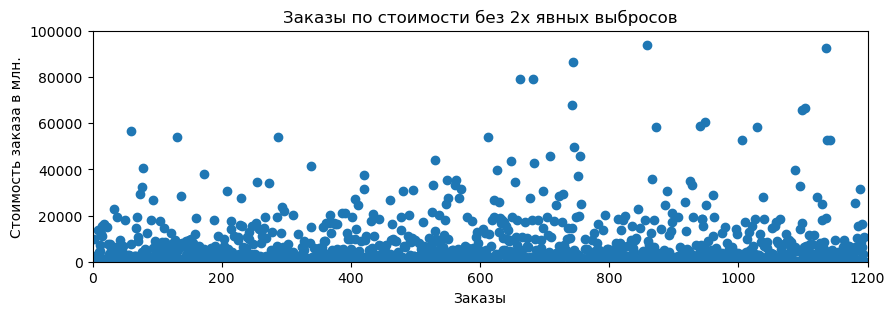

In [340]:
plt.figure(figsize=(10,3))
plt.scatter(x_values,orders['revenue'])
plt.axis([0,1200, 0, 100000])

plt.title('Заказы по стоимости без 2х явных выбросов')
plt.xlabel('Заказы')
plt.ylabel('Стоимость заказа в млн.')

plt.show()

**Вывод:**
- Основная масса заказов по стоимости до ~ 20 000
- Выбиваются 2 заказа: 
    1. Стоимость > 1 200 000
    2. Стоимость > 200 000

In [341]:
(orders.sort_values(by = 'revenue', ascending=False)).head()

,transactionId,visitorId,date,revenue,group
425,590470918,1920142716,2019-08-19,1294500,B
1196,3936777065,2108080724,2019-08-15,202740,B
858,192721366,1316129916,2019-08-27,93940,A
1136,666610489,1307669133,2019-08-13,92550,A
744,3668308183,888512513,2019-08-27,86620,B


### 2.9 Посчитем 95-й и 99-й перцентили стоимости заказов: 
Выберем границу для определения аномальных заказов.

In [342]:
np.percentile(orders['revenue'],[95,99])

array([28000. , 58233.2])

- Не более 5%  заказов имеют стоимость 28000
- Не более 1% заказов имеют стоимость 58233.2

### 2.10 Посчитайте статистическую значимость различий в среднем количестве заказов на посетителя между группами по «сырым» данным:

Сформируем гипотезы:
- H0: различий в среднем количестве заказов между группами нет. 
- H1: различия в среднем между группами есть.

#### Сначала подготовим данные : 

In [343]:
visitors.head()

,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


In [344]:
visitorsADaily = visitors[visitors['group'] == 'A'][['date', 'visitors']]
visitorsADaily.columns = ['date', 'visitorsPerDateA']
visitorsADaily.head()

,date,visitorsPerDateA
0,2019-08-01,719
1,2019-08-02,619
2,2019-08-03,507
3,2019-08-04,717
4,2019-08-05,756


In [345]:
visitorsACummulative = visitorsADaily.apply(
    lambda x: visitorsADaily[visitorsADaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateA': 'sum'}
    ),
    axis=1,
)
visitorsACummulative.columns = ['date', 'visitorsCummulativeA']
visitorsACummulative.head()

,date,visitorsCummulativeA
0,2019-08-01,719
1,2019-08-02,1338
2,2019-08-03,1845
3,2019-08-04,2562
4,2019-08-05,3318


In [346]:
visitorsBDaily = visitors[visitors['group'] == 'B'][['date', 'visitors']]
visitorsBDaily.columns = ['date', 'visitorsPerDateB']
visitorsBDaily.head()

,date,visitorsPerDateB
31,2019-08-01,713
32,2019-08-02,581
33,2019-08-03,509
34,2019-08-04,770
35,2019-08-05,707


In [347]:
visitorsBCummulative = visitorsBDaily.apply(
    lambda x: visitorsBDaily[visitorsBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateB': 'sum'}
    ),
    axis=1,
)
visitorsBCummulative.columns = ['date', 'visitorsCummulativeB']
visitorsBCummulative.head()

,date,visitorsCummulativeB
31,2019-08-01,713
32,2019-08-02,1294
33,2019-08-03,1803
34,2019-08-04,2573
35,2019-08-05,3280


In [348]:
orders.head()

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


In [349]:
ordersADaily = (
    orders[orders['group'] == 'A'][['date', 'transactionId', 'visitorId', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transactionId': pd.Series.nunique, 'revenue': 'sum'})
)
ordersADaily.columns = ['date', 'ordersPerDateA', 'revenuePerDateA']
ordersADaily.head()

,date,ordersPerDateA,revenuePerDateA
0,2019-08-01,24,148579
1,2019-08-02,20,93822
2,2019-08-03,24,112473
3,2019-08-04,16,70825
4,2019-08-05,25,124218


In [350]:
ordersACummulative = ordersADaily.apply(
    lambda x: ordersADaily[ordersADaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateA': 'sum', 'revenuePerDateA': 'sum'}
    ), 
    axis=1,
).sort_values(by=['date'])
ordersACummulative.columns = ['date','ordersCummulativeA','revenueCummulativeA']
ordersACummulative.head()

,date,ordersCummulativeA,revenueCummulativeA
0,2019-08-01,24,148579
1,2019-08-02,44,242401
2,2019-08-03,68,354874
3,2019-08-04,84,425699
4,2019-08-05,109,549917


In [351]:
ordersBDaily = (
    orders[orders['group'] == 'B'][['date', 'transactionId', 'visitorId', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transactionId': pd.Series.nunique, 'revenue': 'sum'})
)
ordersBDaily.columns = ['date', 'ordersPerDateB', 'revenuePerDateB']
ordersBDaily.head()

,date,ordersPerDateB,revenuePerDateB
0,2019-08-01,21,101217
1,2019-08-02,24,165531
2,2019-08-03,16,114248
3,2019-08-04,17,108571
4,2019-08-05,23,92428


In [352]:
ordersBCummulative = ordersBDaily.apply(
    lambda x: ordersBDaily[ordersBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateB': 'sum', 'revenuePerDateB': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersBCummulative.columns = ['date','ordersCummulativeB','revenueCummulativeB']
ordersBCummulative.head()

,date,ordersCummulativeB,revenueCummulativeB
0,2019-08-01,21,101217
1,2019-08-02,45,266748
2,2019-08-03,61,380996
3,2019-08-04,78,489567
4,2019-08-05,101,581995


In [353]:
# Объединим все таблицы в одну: 
data = (
    ordersADaily.merge(
        ordersBDaily, left_on='date', right_on='date', how='left'
    )
    .merge(ordersACummulative, left_on='date', right_on='date', how='left')
    .merge(ordersBCummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsADaily, left_on='date', right_on='date', how='left')
    .merge(visitorsBDaily, left_on='date', right_on='date', how='left')
    .merge(visitorsACummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsBCummulative, left_on='date', right_on='date', how='left')
)
data.head()

,date,ordersPerDateA,revenuePerDateA,ordersPerDateB,revenuePerDateB,ordersCummulativeA,revenueCummulativeA,ordersCummulativeB,revenueCummulativeB,visitorsPerDateA,visitorsPerDateB,visitorsCummulativeA,visitorsCummulativeB
0,2019-08-01,24,148579,21,101217,24,148579,21,101217,719,713,719,713
1,2019-08-02,20,93822,24,165531,44,242401,45,266748,619,581,1338,1294
2,2019-08-03,24,112473,16,114248,68,354874,61,380996,507,509,1845,1803
3,2019-08-04,16,70825,17,108571,84,425699,78,489567,717,770,2562,2573
4,2019-08-05,25,124218,23,92428,109,549917,101,581995,756,707,3318,3280


#### Создадим переменные для пользователей, которые заказывали хотя бы 1 раз, укажем число совершённых заказов:

In [354]:
ordersByUsersA = (
    orders[orders['group'] == 'A']
    .groupby('visitorId', as_index=False)
    .agg({'transactionId': pd.Series.nunique})
)
ordersByUsersA.columns = ['userId', 'orders']
ordersByUsersA.head()

,userId,orders
0,8300375,1
1,11685486,1
2,54447517,1
3,66685450,1
4,78758296,1


In [355]:
ordersByUsersB = (
    orders[orders['group'] == 'B']
    .groupby('visitorId', as_index=False)
    .agg({'transactionId': pd.Series.nunique})
)
ordersByUsersB.columns = ['userId', 'orders']
ordersByUsersB.head()

,userId,orders
0,5114589,1
1,6958315,1
2,8300375,1
3,39475350,1
4,47206413,1


#### Подготовим выборки к проверке критерием Манна-Уитни.
Для этого объявим переменные в которых пользователям из разных групп будет соответствовать количество заказов.
Тем, кто ничего не заказал, будут соответствовать нули.

In [356]:
sampleA = (
    pd.concat([ordersByUsersA['orders'],
               pd.Series(0, index=np.arange(data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])),
                         name='orders')],axis=0)
)
sampleA.head()

0    1
1    1
2    1
3    1
4    1
Name: orders, dtype: int64

In [357]:
sampleB = (
    pd.concat([ordersByUsersB['orders'],
               pd.Series(0, index=np.arange(data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])),
                         name='orders')],axis=0)
)
sampleB.head()

0    1
1    1
2    1
3    1
4    1
Name: orders, dtype: int64

In [358]:
print('p-value =',"{0:.3f}".format(stats.mannwhitneyu(sampleA, sampleB)[1]))

p-value = 0.017


In [359]:
print('Относительный прирост среднего числа заказов группы B =',"{0:.3f}".format(sampleB.mean() / sampleA.mean() - 1))

Относительный прирост среднего числа заказов группы B = 0.138


**Вывод:**
- В результате теста по сырым данным получили p-value = 0.017, что меньше alpha = 0.05
 - Значит можем отвергнуть H0 и **различия в среднем количестве заказов на посетителя между группами есть**.
 - Относительный прирост среднего числа заказов группы B = 13.8 %

### 2.11 Посчитайте статистическую значимость различий в среднем чеке заказа между группами по «сырым» данным: 

Сформируем гипотезы:
- H0: различий в среднем чеке между группами нет. 
- H1: различия в среднем чеке между группами есть. 

In [360]:
print('p-value = ','{0:.3f}'.format(stats.mannwhitneyu(
    orders[orders['group']=='A']['revenue'], orders[orders['group']=='B']['revenue'])[1]))

p-value =  0.729


In [361]:
print('Относительные различия в среднем чеке между группами = ','{0:.3f}'.format(
    orders[orders['group']=='B']['revenue'].mean()/orders[orders['group']=='A']['revenue'].mean()-1))

Относительные различия в среднем чеке между группами =  0.259


**Вывод:**
- P-value значительно больше 0.05. Значит, **причин отвергать нулевую гипотезу и считать, что в среднем чеке есть различия, нет**. 
- При этом Средний чек группы B значительно больше среднего чека группы A, на ~ 26%

### 2.12 Посчитаем статистическую значимость различий в среднем количестве заказов на посетителя между группами по «очищенным» данным (без аномальных заказов):

Сформируем гипотезы:
- H0: различий в среднем количестве заказов на посетителя между группами нет. 
- H1: различия в среднем количестве заказов на посетителя между группами есть. 

Исходя из результатов в п 2.7 и 2.9:
- Примем за аномальных пользователей тех, кто совершил более 2х заказов или совершил заказ дороже 28000.


#### Узнаем сколько всего аномальных пользователей: 

In [362]:
usersWithManyOrders = pd.concat(
    [
        ordersByUsersA[ordersByUsersA['orders'] > 2]['userId'],
        ordersByUsersB[ordersByUsersB['orders'] > 2]['userId'],
    ],
    axis=0,
)

In [363]:
orders.head()

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


In [364]:
usersWithExpensiveOrders = orders[orders['revenue'] > 20000]['visitorId']

In [365]:
abnormalUsers = (
    pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis=0)
    .drop_duplicates()
    .sort_values()
)

print(abnormalUsers.head(5))
print('Количество аномальных пользователей:',abnormalUsers.shape[0])

568     113298937
1099    148427295
461     154576532
18      199603092
928     204675465
dtype: int64
Количество аномальных пользователей: 100


#### Подготовим выборки количества заказов по пользователям по группам теста:

In [366]:
sampleAFiltered = pd.concat(
    [
        ordersByUsersA[
            np.logical_not(ordersByUsersA['userId'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

In [367]:
sampleBFiltered = pd.concat(
    [
        ordersByUsersB[
            np.logical_not(ordersByUsersB['userId'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
) 

#### Применим статистический критерий Манна-Уитни к полученным выборкам:

In [368]:
print('p-value =','{0:.3f}'.format(stats.mannwhitneyu(sampleAFiltered, sampleBFiltered)[1]))

p-value = 0.018


In [369]:
print('Относительный прирост в среднем количестве заказов на посетителя группы B = ','{0:.3f}'.format(sampleBFiltered.mean()/sampleAFiltered.mean()-1)) 

Относительный прирост в среднем количестве заказов на посетителя группы B =  0.170


 **Вывод:**
 - В результате теста по очищенным данным получили p-value = 0.018, что меньше alpha = 0.05 (0.017 - грязные данные)
 - Значит можем отвергнуть H0 и **различия в среднем количестве заказов на посетителя между группами есть**.
 - Относительный прирост среднего числа заказов группы B = 0.170 (13.8 % - грязные данные)
 - Результат теста по очищенным данным подтвердил изначальный тест по "сырым" данным
 - Относительный прирост по ощиенным данным даже выше!

### 2.13 Посчитайте статистическую значимость различий в среднем чеке заказа между группами по «очищенным» данным. 
Сделайте выводы и предположения.

Сформируем гипотезы:
- H0:  различий в среднем чеке заказа между группами нет. 
- H1:  различия в среднем чеке заказа между группами есть. 

In [370]:
print(
    'p-value = ','{0:.3f}'.format(
        stats.mannwhitneyu(
            orders[
                np.logical_and(
                    orders['group'] == 'A',
                    np.logical_not(orders['visitorId'].isin(abnormalUsers)),
                )
            ]['revenue'],
            orders[
                np.logical_and(
                    orders['group'] == 'B',
                    np.logical_not(orders['visitorId'].isin(abnormalUsers)),
                )
            ]['revenue'],
        )[1]
    )
)

p-value =  0.698


In [371]:
print(
    'Относительный прирост в среднем чеке заказа группы B =',"{0:.3f}".format(
        orders[
            np.logical_and(
                orders['group'] == 'B',
                np.logical_not(orders['visitorId'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        / orders[
            np.logical_and(
                orders['group'] == 'A',
                np.logical_not(orders['visitorId'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        - 1
    )
)

Относительный прирост в среднем чеке заказа группы B = -0.030


**Вывод:**
- P-value 0.698 значительно больше alpha 0.05. 
    - Значит, **причин отвергать нулевую гипотезу и считать, что в среднем чеке есть различия, нет**. 
- При этом относительной разницы в Среднем чеке группы B по сравнению с группой A, почти нет (всего 3%)

### 2.14 Итоговый вывод по результатам теста:
#### Варианты решений:
1. Остановить тест, зафиксировать победу одной из групп.
2. Остановить тест, зафиксировать отсутствие различий между группами.
3. Продолжить тест.

#### Суммируем факты собранные в ходе исследования:
Исходя из результатов стат тестов и графиков следует: 
 1. По "сырым" и "очищенным" данным **ЕСТЬ статистически значимые различия в кол-ве заказов на 1го посетителя**. По очищенным данным прирост гр B = 17%
 2. По "сырым" и "очищенным" данным **НЕТ статистически значимых различий в сумме среднего чека на 1 заказ**. По очищенным данным прирост гр B = - 3%
 3. График различия среднего количества заказов между группами сообщает, что результаты группы B втечение месяца росли и к концу месяца сравнялись с группой А и **имеют тенденцию к росту, либо зафиксировались около среднего значения.**
 
**Решение:**  Исходя из вышеперечисленных фактов останавливаем тест и признаём его успешным. Группа B - лучше.
 
